# Exploring coffee data
dataset: https://github.com/jldbc/coffee-quality-database/tree/master

## Import and cleanup

In [134]:
# Import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy
import cartopy.crs as crss
import cartopy.feature as cfeat
import cartopy.io.shapereader as shpreader

sns.set(style="ticks")
import warnings
warnings.filterwarnings('ignore')

In [135]:
# Read dataset
df = pd.read_csv("coffee-quality-database-master/data/arabica_data_cleaned.csv").drop("Unnamed: 0", axis=1)
# df_robusta = pd.read_csv("coffee-quality-database-master/data/robusta_data_cleaned.csv").drop("Unnamed: 0", axis=1)
# df = df.append(df_robusta, sort=False, ignore_index=True)

In [136]:
# Look at first entries
df.head()

,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,NaN,...,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
3,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,oromia,...,Green,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0
4,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


In [137]:
# Experimental removal of unneeded information and transformation of the necessary when needed.
df = df.drop(['Altitude', 'Lot.Number', 'Number.of.Bags', 'Bag.Weight', 
              'Owner', 'Certification.Address', 'Certification.Contact'], axis=1)
df = df.rename({'Owner.1': 'Owner'}, axis=1)

# to lowercase
df = df.rename({
    name: name.lower().replace('.', '_') for name in df.columns.values.tolist()
}, axis='columns')

# Convert all height values to meters.
def convertToMeters(x):
    if x['unit_of_measurement'] == "ft":
        x['altitude_low_meters'] *= 0.3048
        x['altitude_high_meters'] *= 0.3048
        x['altitude_mean_meters'] *= 0.3048
    return x
    
df = df.apply(convertToMeters, axis=1).drop(['unit_of_measurement'], axis=1)

In [138]:
# Look at descriptions
print(df.info())
print("\n", df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 35 columns):
species                 1311 non-null object
country_of_origin       1310 non-null object
farm_name               955 non-null object
mill                    1001 non-null object
ico_number              1165 non-null object
company                 1102 non-null object
region                  1254 non-null object
producer                1081 non-null object
in_country_partner      1311 non-null object
harvest_year            1264 non-null object
grading_date            1311 non-null object
owner                   1304 non-null object
variety                 1110 non-null object
processing_method       1159 non-null object
aroma                   1311 non-null float64
flavor                  1311 non-null float64
aftertaste              1311 non-null float64
acidity                 1311 non-null float64
body                    1311 non-null float64
balance                 1311 non-n

In [139]:
df.head(10)

,species,country_of_origin,farm_name,mill,ico_number,company,region,producer,in_country_partner,harvest_year,...,moisture,category_one_defects,quakers,color,category_two_defects,expiration,certification_body,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,Arabica,Ethiopia,metad plc,metad plc,2014/2015,metad agricultural developmet plc,guji-hambela,METAD PLC,METAD Agricultural Development plc,2014,...,0.12,0,0.0,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,1950.0,2200.0,2075.0
1,Arabica,Ethiopia,metad plc,metad plc,2014/2015,metad agricultural developmet plc,guji-hambela,METAD PLC,METAD Agricultural Development plc,2014,...,0.12,0,0.0,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,1950.0,2200.0,2075.0
2,Arabica,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,NaN,Specialty Coffee Association,NaN,...,0.00,0,0.0,NaN,0,"May 31st, 2011",Specialty Coffee Association,1600.0,1800.0,1700.0
3,Arabica,Ethiopia,yidnekachew dabessa coffee plantation,wolensu,NaN,yidnekachew debessa coffee plantation,oromia,Yidnekachew Dabessa Coffee Plantation,METAD Agricultural Development plc,2014,...,0.11,0,0.0,Green,2,"March 25th, 2016",METAD Agricultural Development plc,1800.0,2200.0,2000.0
4,Arabica,Ethiopia,metad plc,metad plc,2014/2015,metad agricultural developmet plc,guji-hambela,METAD PLC,METAD Agricultural Development plc,2014,...,0.12,0,0.0,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,1950.0,2200.0,2075.0
5,Arabica,Brazil,NaN,NaN,NaN,NaN,NaN,NaN,Specialty Coffee Institute of Asia,2013,...,0.11,0,0.0,Bluish-Green,1,"September 3rd, 2014",Specialty Coffee Institute of Asia,NaN,NaN,NaN
6,Arabica,Peru,NaN,hvc,NaN,richmond investment-coffee department,NaN,HVC,Specialty Coffee Institute of Asia,2012,...,0.11,0,0.0,Bluish-Green,0,"September 17th, 2013",Specialty Coffee Institute of Asia,NaN,NaN,NaN
7,Arabica,Ethiopia,aolme,c.p.w.e,010/0338,NaN,oromia,Bazen Agricultural & Industrial Dev't Plc,Ethiopia Commodity Exchange,March 2010,...,0.03,0,0.0,NaN,0,"September 2nd, 2011",Ethiopia Commodity Exchange,1570.0,1700.0,1635.0
8,Arabica,Ethiopia,aolme,c.p.w.e,010/0338,NaN,oromiya,Bazen Agricultural & Industrial Dev't Plc,Ethiopia Commodity Exchange,March 2010,...,0.03,0,0.0,NaN,0,"September 2nd, 2011",Ethiopia Commodity Exchange,1570.0,1700.0,1635.0
9,Arabica,Ethiopia,tulla coffee farm,tulla coffee farm,2014/15,diamond enterprise plc,"snnp/kaffa zone,gimbowereda",Diamond Enterprise Plc,METAD Agricultural Development plc,2014,...,0.10,0,0.0,Green,4,"March 29th, 2016",METAD Agricultural Development plc,1795.0,1850.0,1822.5


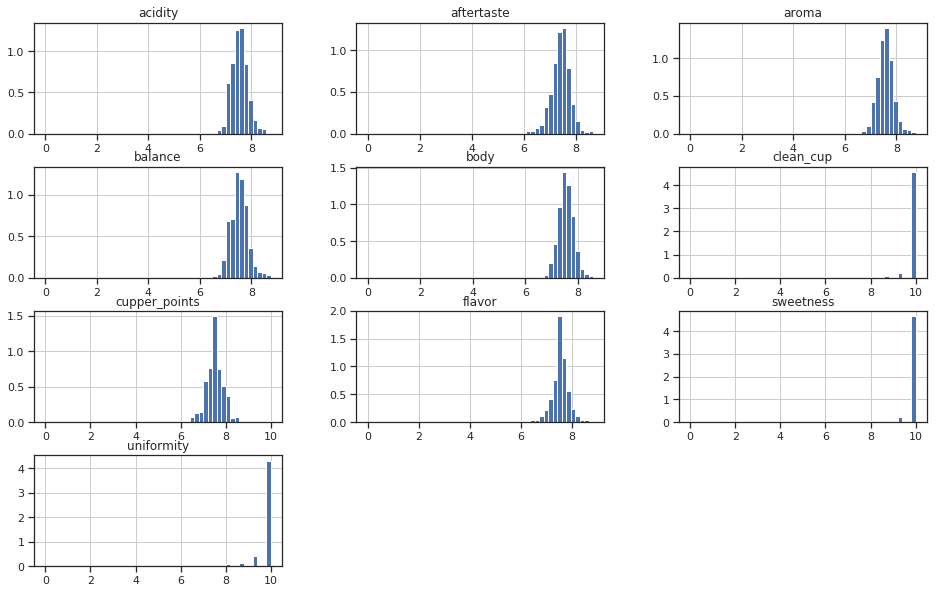

In [140]:
score_cols = ['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance', 'uniformity', 'clean_cup', 'sweetness', 'cupper_points']
ax = df[df.species == 'Arabica'].hist(column=score_cols, bins=50, figsize=(16,10), sharey=False, normed=True)
# ax = [item for sublist in ax for item in sublist]
# ax = df[df.species == 'Robusta'].hist(column=score_cols, bins=50, figsize=(16,10), sharey=False, normed=True, ax = ax[1:11])


# metled = df[score_cols + ['species']].melt(['species'], var_name='cols',  value_name='vals')

# g = sns.FacetGrid(metled, col='cols', hue="species", col_wrap=3, sharey=False, aspect=1.5)
# g.map(sns.distplot, 'vals', hist=True)

# Plotting on World Map

In [157]:
# Setting colours to countries.
# Using https://matthewkudija.com/blog/2018/05/25/country-maps/
# as reference.

def plot_countries(df, column, projection, title, edgecolor):
    # Basic map shared for 
    plt.figure(figsize=(20,10))
    ax = plt.axes(projection=projection)
    ax.add_feature(cartopy.feature.OCEAN, facecolor='white')
    ax.outline_patch.set_edgecolor(edgecolor)
    
    # Loading in data for country borders
    shpfilename = shpreader.natural_earth(
        resolution='110m',
        category='cultural',
        name='admin_0_countries')
    
    # Read data from natural_earth.
    reader = shpreader.Reader(shpfilename)
    # Get countries.
    countries = reader.records()
    # Get values from the dataframe.
    values = list(df[column].unique())
    
    for country in countries:
        # See https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/
        attribute = 'ADM0_A3'
        ADM0_A3 = country.attributes['ADM0_A3']
        
        # Get classification
        try:
            # .loc[country.attributes[attribute]] should give the df of countries
            # according to ADMO_A3.
            classification = df.loc[country.attributes[attribute]][column]
        except:
            pass
        
        # Plot country geometries onto map
#                           facecolor=(colors[values.index(classification)]),
        ax.add_geometries(country.geometry, crss.PlateCarree(),
                          facecolor=classification,
                          label=country.attributes[attribute],
                          edgecolor='#FFFFFF',
                          linewidth=0.25)
    
    plt.title(title, fontsize=18)

    title = 'maps/'+title+'.png'
    # plt.savefig(title, bbox_inches='tight', pad_inches=.2, dpi=300)
    # print('Saved: {}'.format(title))
    return ax

In [158]:
df_countries = pd.read_csv('countries.csv', index_col='ISO_CODE')
df_countries.head()

# Confirm all countries in coffee dataset exist within full country dataset.
coffee_countries = df.country_of_origin.values
all_countries = df_countries['COUNTRY_NAME'].values

wrong_name = set([c for c in coffee_countries if c not in all_countries])

print("\n\n", wrong_name)



 {nan}


[None, None]

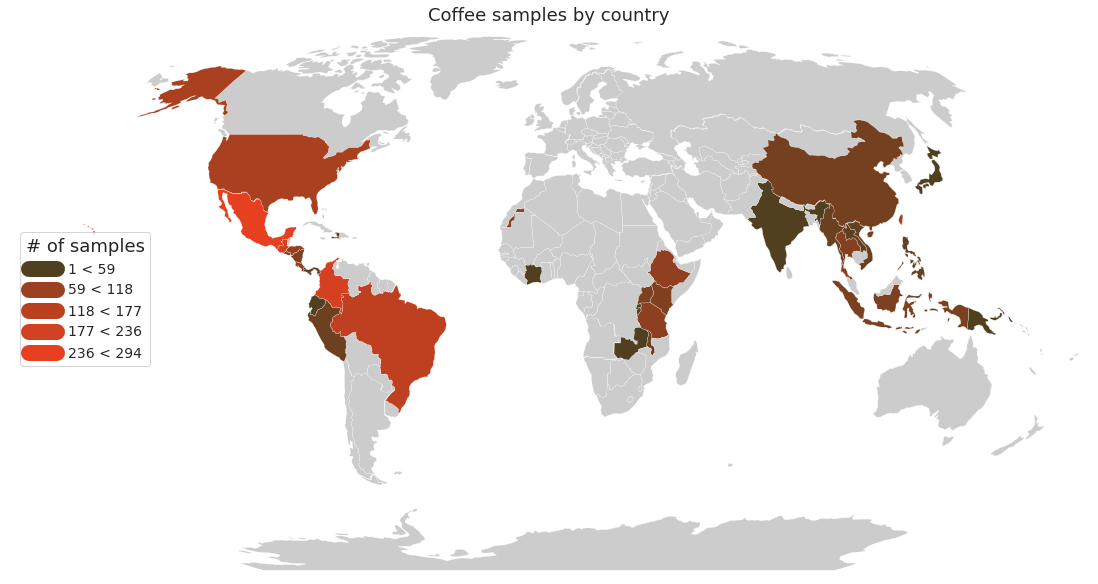

In [185]:
# g.axes[0].legend()
projection = crss.Robinson()
colors = ['#ff2222', '#550055']
title='Coffee samples by country'

df.country_of_origin = df.country_of_origin.replace({
    'Tanzania, United Republic Of': 'Tanzania',
    'Cote d?Ivoire': 'Cote d\'Ivoire',
    'United States (Puerto Rico)': 'United States of America',
    'United States (Hawaii)': 'United States of America',
    'United States': 'United States of America',
})

df_countries = df_countries.copy()

counts = df.country_of_origin.value_counts().to_dict()
min_count = min(counts.values())
max_count = max(counts.values())

def pct_to_color(pct):
    pct = max(0, min(pct**0.5 * 150 + 80, 255))
    return f"#{'{:02X}'.format(int(pct))}4020"
    
def color(name):
    if not name in df.country_of_origin.values:
        return "#cccccc"
    
    pct = (counts[name] - min_count) / (max_count - min_count)
    return pct_to_color(pct)

df_countries['color'] = df_countries['COUNTRY_NAME'].apply(color)

annotation='yay this works'
edgecolor='white'

ax = plot_countries(df_countries, 'color', projection, annotation, title, edgecolor='white')

n = 5
to_count = lambda pct: int(pct * (max_count - min_count) + min_count)
labels = [f'{to_count(i/(n-1))} < {to_count((i+1)/(n-1))}' for i in range(n)]
custom_lines = [matplotlib.lines.Line2D([0], [0], color=pct_to_color(c/(n-1)), lw=16) for c in range(n)]

legend = ax.legend(custom_lines, labels, loc='center left', fontsize=14, title='# of samples')
plt.setp(legend.get_title(),fontsize='18')